1. Произвести масштабирование признаков (scaling).
2. С использованием библиотеки scikit-learn написать программу с использованием алгоритмов кластеризации данных, позволяющую разделить исходную выборку на классы, соответствующие предложенной вариантом задаче (http://scikit-learn.org/stable/modules/clustering.html).
3. Провести эксперименты и определить наилучший алгоритм кластеризации, параметры алгоритма. Необходимо использовать не менее 3-х алгоритмов. Данные экспериментов необходимо представить в отчете (графики, ход проведения эксперимента, выводы).
Массивы данных берутся из UCI Machine Learning Repository

Загрузка и предварительная обработка данных
Для начала загрузим данные и извлечем текстовые данные из XML-файлов. Предполагается, что XML-файл называется nysk.xml.

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка и подготовка данных
# Загрузка XML-файла
tree = ET.parse('nysk.xml')
root = tree.getroot()

# Извлечение текста и других признаков из документов
documents = []
for doc in root.findall('document'):
    text = doc.find('text').text
    documents.append(text)

# Преобразование текста в DataFrame
df = pd.DataFrame(documents, columns=['text'])


1. Произвести масштабирование признаков (scaling).

In [3]:
# Преобразование текста в числовые признаки с использованием TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['text'])

# Масштабирование признаков
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Преобразование разреженной матрицы в плотную для некоторых алгоритмов
X_dense = X_scaled.toarray()

# Снижение размерности с использованием PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)


2. С использованием библиотеки scikit-learn написать программу с использованием алгоритмов кластеризации данных, позволяющую разделить исходную выборку на классы, соответствующие предложенной вариантом задаче.

In [4]:
# Алгоритмы кластеризации
algorithms = {
    'KMeans': KMeans(n_clusters=5, random_state=42),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=5),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}


3. Провести эксперименты и определить наилучший алгоритм кластеризации, параметры алгоритма. Необходимо использовать не менее 3-х алгоритмов. Данные экспериментов необходимо представить в отчете (графики, ход проведения эксперимента, выводы).

KMeans Silhouette Score: 0.4067753772043902
AgglomerativeClustering Silhouette Score: 0.35742141846726716
DBSCAN Silhouette Score: -0.172442497881566


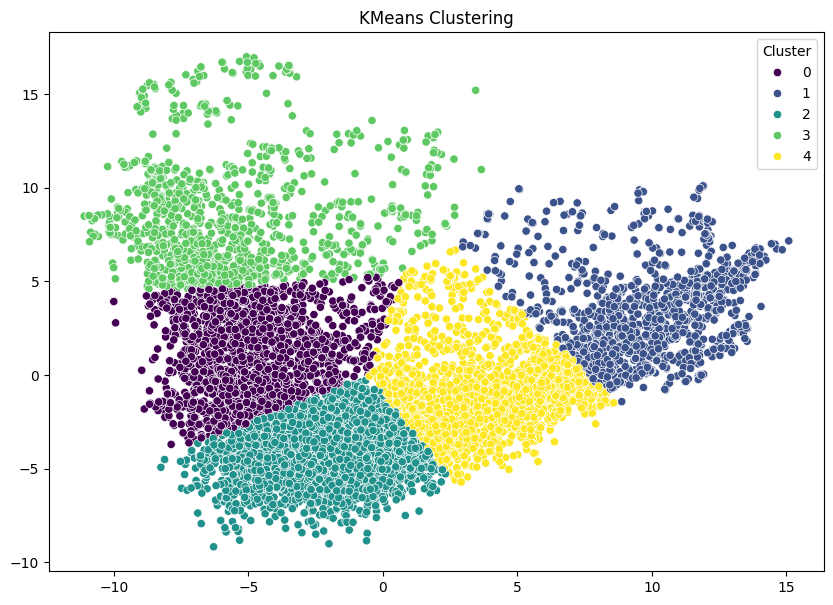

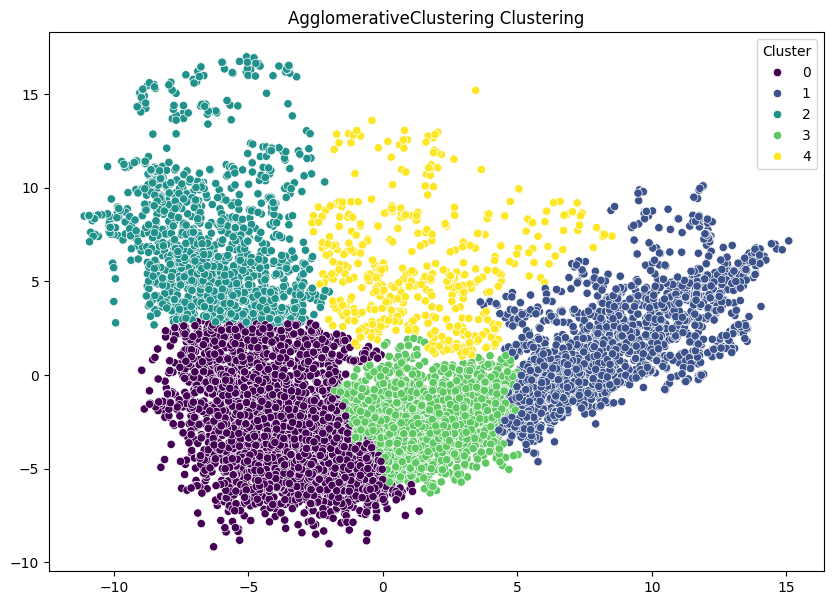

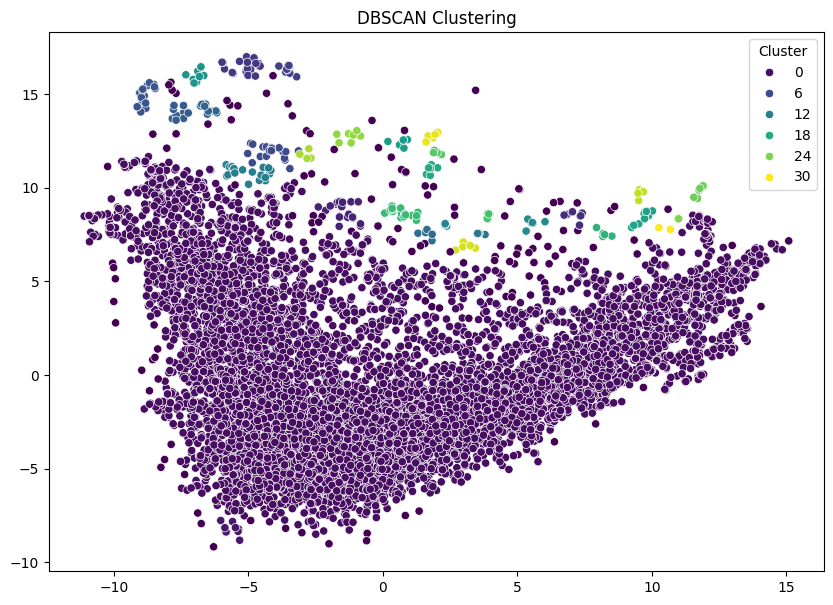

Best Algorithm: KMeans with Silhouette Score: 0.4067753772043902


In [5]:
def evaluate_clustering(model, X):
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return score, labels


# Проведение экспериментов и оценка результатов
results = {}
for name, algorithm in algorithms.items():
    score, labels = evaluate_clustering(algorithm, X_pca)
    results[name] = (score, labels)
    print(f'{name} Silhouette Score: {score}')

# Визуализация результатов
for name, (score, labels) in results.items():
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis')
    plt.title(f'{name} Clustering')
    plt.legend(title='Cluster')
    plt.show()

# Определение наилучшего алгоритма
best_algorithm = max(results, key=lambda k: results[k][0])
best_score = results[best_algorithm][0]
print(f'Best Algorithm: {best_algorithm} with Silhouette Score: {best_score}')


Best params: {'eps': 0.9, 'min_samples': 3}
Optimized DBSCAN Silhouette Score: 0.2263632093393092


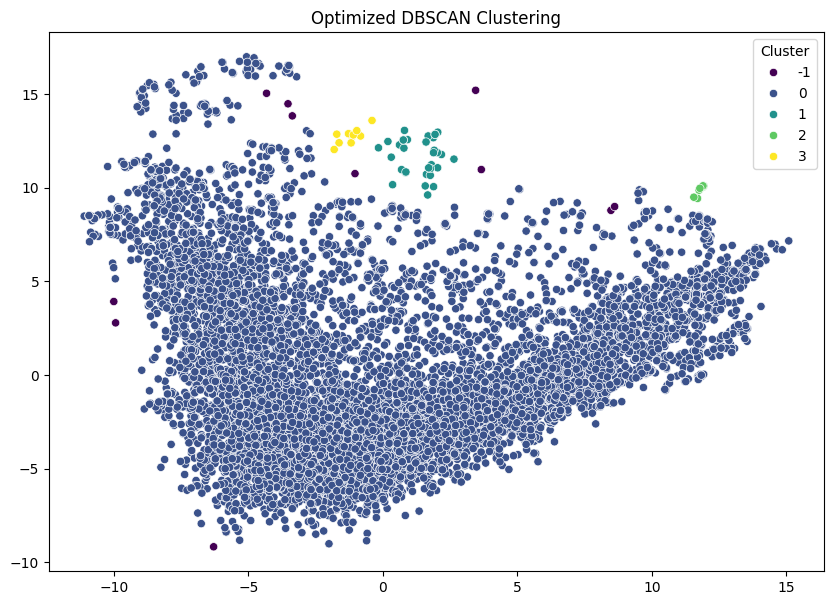

In [6]:

from sklearn.model_selection import GridSearchCV

# Подбор гиперпараметров для DBSCAN с использованием GridSearchCV
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:  # как минимум два кластера
        return silhouette_score(X, labels)
    else:
        return -1  # если все данные в одном кластере, результат отрицательный

param_grid = {
    'eps': [0.4, 0.5, 0.7, 0.9],
    'min_samples': [2, 3, 5, 10]
}

dbscan = DBSCAN()
grid_search = GridSearchCV(dbscan, param_grid, scoring=silhouette_scorer)
grid_search.fit(X_pca)

print(f"Best params: {grid_search.best_params_}")
best_dbscan = grid_search.best_estimator_
score, labels = evaluate_clustering(best_dbscan, X_pca)
print(f'Optimized DBSCAN Silhouette Score: {score}')

# Визуализация оптимизированного DBSCAN
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis')
plt.title('Optimized DBSCAN Clustering')
plt.legend(title='Cluster')
plt.show()
